## Imports

In [16]:
import os
import sys

import numpy as np

sys.path.insert(0, './src')

from deepverse.parameter import ParameterManager
from deepverse.scenario import ScenarioManager
from deepverse.datasets.dataset import Dataset 

from deepverse.visualizers import ImageVisualizer, LidarVisualizer

## Parameter reading

In [17]:
# Create the directory if it doesn't exist
folder = 'params'
if not os.path.exists(folder):
    os.makedirs(folder)

# Path to the MATLAB configuration file
config_path = os.path.join(folder, "config.m")

# Initialize ParameterManager and load parameters
param_manager = ParameterManager(config_path)
params = param_manager.get_params()

# Print the loaded parameters
print("Loaded Parameters:")
print(params)

Loaded Parameters:
{'basestations': [1], 'dataset_folder': 'D:/Deepverse_data/scenarios', 'scenario': 'DT31', 'scenes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'comm': {'enable': True, 'bs_antenna': {'shape': [16, 1], 'rotation': [0, 0, -45.04], 'spacing': 0.5, 'FoV': [360, 180]}, 'ue_antenna': {'shape': [1, 1], 'rotation': [0, 0, 0], 'spacing': 0.5, 'FoV': [360, 180]}, 'OFDM': {'bandwidth': 0.05, 'subcarriers': 512, 'selected_subcarriers': [0, 1, 2, 3, 4, 5, 6, 7]}, 'activate_RX_filter': 0, 'generate_OFDM_channels': 1, 'num_paths': 25, 'enable_Doppler': 1}, 'radar': {'enable': False, 'tx_antenna': {'shape': [1, 1], 'rotation': [0, 0, -45

## Generate a dataset

In [18]:
%%capture
# Generate a dataset
dataset = Dataset(config_path)

## Access a channel

In [19]:
# Channel between BS1 and user can be accessed here
channel = dataset.get_sample('comm-ue', index=0, bs_idx=0, ue_idx=0).coeffs

## Plot BS beam power and user position

### Simple beam-steering codebook

In [20]:
def beam_steering_codebook(angles, num_z, num_x):
    d = 0.5
    k_z = np.arange(num_z)
    k_x = np.arange(num_x)
    
    codebook = []
    
    for beam_idx in range(angles.shape[0]):
        z_angle = angles[beam_idx, 0]
        x_angle = angles[beam_idx, 1]
        bf_vector_z = np.exp(1j * 2 * np.pi * k_z * d * np.cos(np.radians(z_angle)))
        bf_vector_x = np.exp(1j * 2 * np.pi * k_x * d * np.cos(np.radians(x_angle)))
        bf_vector = np.outer(bf_vector_z, bf_vector_x).flatten()
        codebook.append(bf_vector)
    
    return np.stack(codebook, axis=0)

# Construct beam steering codebook
num_angles = 64
x_angles = np.linspace(0, 180, num_angles + 1)[1:]
x_angles = np.flip(x_angles)
z_angles = np.full(num_angles, 90)
beam_angles = np.column_stack((z_angles, x_angles))
codebook = beam_steering_codebook(beam_angles, 1, 16)

### Apply beam-steering codebook to channels

In [21]:
# Apply codebook to bs-ue comm channel
beam_power = []
ue_loc = []
num_scene = len(dataset.params['scenes'])
for i in range(num_scene):
    channel = dataset.get_sample('comm-ue', index=i, bs_idx=0, ue_idx=0).coeffs
    ue_loc_ = dataset.get_sample('loc-ue', index=i, bs_idx=0, ue_idx=0)
    
    beam_power_ = (np.abs(codebook @ np.squeeze(channel, -2))**2).sum(-1)
    beam_power.append(beam_power_)

    ue_loc.append(ue_loc_)

bs_loc = dataset.get_sample('loc-bs', index=0, bs_idx=0, ue_idx=0)

### Plot video

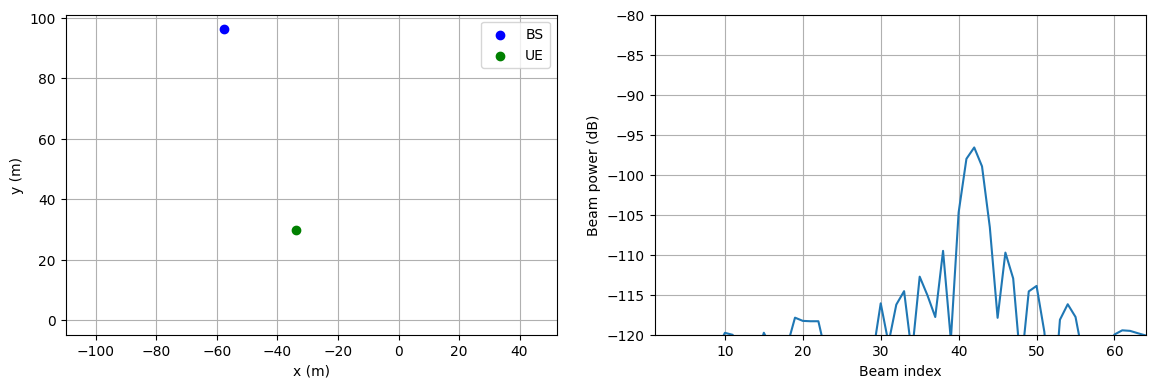

In [22]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# fig.subplots_adjust(hspace=0.5)

# Initialize plots
axes[0].scatter(bs_loc[0], bs_loc[1], color='b', label='BS')
ue_scatter = axes[0].scatter([0], [0], color='g', label='UE')
axes[0].set_xlim([-100, 100])
axes[0].set_ylim([0, 120])
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True)

line, = axes[1].plot(range(1, num_angles + 1), 10 * np.log10(beam_power[0]))
axes[1].set_xlim([1, num_angles])
axes[1].set_ylim([-120, -80])
axes[1].set_xlabel('Beam index')
axes[1].set_ylabel('Beam power (dB)')
axes[1].grid(True)

fig.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.15)



# Update function for animation
def update(i):
    ue_scatter.set_offsets([ue_loc[i][0], ue_loc[i][1]])  # Update UE location
    line.set_data(range(1, num_angles + 1), 10 * np.log10(beam_power[i]))  # Update beam power
    return ue_scatter, line

# Create animation
ani = FuncAnimation(fig, update, frames=num_scene, interval=100, blit=True)

# Display the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml(default_mode="once"))